In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns; sns.set()


# Data Acquisition

In [3]:
converters = dict(
    id=str,
    desc=str,
    hardship_type=str,
    hardship_reason=str,
    hardship_status=str,
    hardship_loan_status=str,
    verification_status_joint=str
)
dates = [
    'next_pymnt_d',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'earliest_cr_line',
    'issue_d'
]

In [6]:
# Imports loan data

df = pd.DataFrame()
#files = os.listdir('./Source Data/Loan Data')
files = os.listdir('C:/Users/Vikram/Documents/HES/Intro To Data Science/Final Project/Loan Data2')
csvs = []
for file in files:
    if re.match('.*csv$',file):
        csvs += [file]
cols = df.dtypes
for csv in csvs:
    path = 'C:/Users/Vikram/Documents/HES/Intro To Data Science/Final Project/Loan Data2/' + csv
    tdf = pd.read_csv(path,header=1,low_memory=False,)
    df=df.append(tdf)
df.reset_index(inplace=True) # This will help with joining back data if necessary.

In [7]:
pd.set_option('display.max_rows', 151)
print(df.dtypes)
pd.set_option('display.max_rows', 20)

index                                           int64
id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                  

In [8]:
# Checks for duplicates within our combined data
df['count']=1 # Generate field to measure the number of occurances

counts = df.groupby('id')['count'].count()
print('Data are duplicated %i times.' % len(counts[counts>1]))

Data are duplicated 0 times.


Data are duplicated 0 times.
Some data are not useful as a predictor. Because we are going to use these data as a training set, we need to remove data that are not useful for predictions. There are two categories of data that are not useful for predictions. First, we need information about loans that have fully run their course. That is to say, we need to see loans that have either been paid in full or written off. It is not useful to see loans that are currently delinquent or current on payments but still early in the loan. Second, we need to remove predictors that are not import for predicting the loan. For example the URL has no impact on the borrower's ability to repay the loan. If we need this data in the future, we can still pair it back with the original dataframe.

In [9]:
has_data = {}
for column in df.columns:
    has_data[column] = len(df[column].dropna())
has_data

{'acc_now_delinq': 1873261,
 'acc_open_past_24mths': 1823260,
 'addr_state': 1873290,
 'all_util': 1007043,
 'annual_inc': 1873286,
 'annual_inc_joint': 68056,
 'application_type': 1873290,
 'avg_cur_bal': 1802974,
 'bc_open_to_buy': 1803433,
 'bc_util': 1802461,
 'chargeoff_within_12_mths': 1873145,
 'collection_recovery_fee': 1873290,
 'collections_12_mths_ex_med': 1873145,
 'count': 1873317,
 'debt_settlement_flag': 1873290,
 'debt_settlement_flag_date': 21652,
 'deferral_term': 7288,
 'delinq_2yrs': 1873261,
 'delinq_amnt': 1873261,
 'desc': 126068,
 'disbursement_method': 1873290,
 'dti': 1872449,
 'dti_joint': 68052,
 'earliest_cr_line': 1873261,
 'emp_length': 1873290,
 'emp_title': 1751373,
 'fico_range_high': 1873290,
 'fico_range_low': 1873290,
 'funded_amnt': 1873290,
 'funded_amnt_inv': 1873290,
 'grade': 1873290,
 'hardship_amount': 7288,
 'hardship_dpd': 7288,
 'hardship_end_date': 7288,
 'hardship_flag': 1873290,
 'hardship_last_payment_amount': 7288,
 'hardship_length':

Based on the data, it appears that joint applications are a fairly new development in these data. We see only about 50,000 instances where the data are included for joint applications. The following visualization shows the relationship for income in joint applicants.

In [12]:
joint_fil = (df['annual_inc']>0)&(df['annual_inc_joint']>0)
plt.scatter(df[joint_fil]['annual_inc'],df[joint_fil]['annual_inc_joint'])
plt.title('Income vs. Joint Income')
plt.xlabel('Annual income')
plt.ylabel('Annual income joint')
plt.show;


Because of the high risk of multicolinearity, and the small number of observations, we are dropping this from the dataset. We will still keep a dummy variable that treats joint applications differently, but we will not consider the joint income of applicants.

In [13]:
# Limit to loans that are paid in full or written off. Uses dates so that 
# loans that are delinquent are not disproportionaltely dropped from data
# Convert the loan issue date to a datetime
df['issue_d'] = pd.to_datetime(df['issue_d'])
mature_filter = (df['loan_status']=='Fully Paid')|(df['loan_status']=='Charged Off')
#latest_mature = df[~mature_filter]['issue_d'].min()
#latest_mature
#reduced_df = df[df['issue_d']<=latest_mature]
reduced_df = df[mature_filter] # Pulls only loans that are charged off or paid in full.
#
## Use my documentation to filter to only 
data_dict = pd.read_excel('./Source Data/LCDataDictionary.xlsx',sheet_name='LoanStats')
features = list(data_dict[data_dict['Useful Predictor']=='Yes']['LoanStatNew'].values)
reduced_df=reduced_df[features]

# Combines fields when necessary
reduced_df['fico_est'] = (reduced_df['fico_range_low']+reduced_df['fico_range_high'])/2
reduced_df.drop(columns=[
    'fico_range_low',
    'fico_range_high',
],inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: './Source Data/LCDataDictionary.xlsx'

In [15]:
n_options = {}
for column in reduced_df.columns:
    n_options[column] = len(reduced_df[column].unique())
n_options

{'acc_now_delinq': 8,
 'acc_open_past_24mths': 52,
 'addr_state': 51,
 'all_util': 164,
 'annual_inc': 53722,
 'annual_inc_joint': 2386,
 'application_type': 2,
 'avg_cur_bal': 71151,
 'bc_open_to_buy': 67224,
 'bc_util': 1401,
 'chargeoff_within_12_mths': 11,
 'collection_recovery_fee': 110376,
 'collections_12_mths_ex_med': 15,
 'count': 1,
 'debt_settlement_flag': 2,
 'debt_settlement_flag_date': 75,
 'deferral_term': 2,
 'delinq_2yrs': 30,
 'delinq_amnt': 1642,
 'desc': 119953,
 'disbursement_method': 2,
 'dti': 5648,
 'dti_joint': 2989,
 'earliest_cr_line': 722,
 'emp_length': 12,
 'emp_title': 321445,
 'fico_range_high': 40,
 'fico_range_low': 40,
 'funded_amnt': 1526,
 'funded_amnt_inv': 8992,
 'grade': 7,
 'hardship_amount': 2469,
 'hardship_dpd': 34,
 'hardship_end_date': 17,
 'hardship_flag': 1,
 'hardship_last_payment_amount': 2421,
 'hardship_length': 2,
 'hardship_loan_status': 6,
 'hardship_payoff_balance_amount': 2593,
 'hardship_reason': 10,
 'hardship_start_date': 17,


Based on these results, we will have to encode several data as dummy variables:

home_ownership
term
application_type
verification_status

In [16]:
has_data = {}
for column in reduced_df.columns:
    has_data[column] = len(reduced_df[column].dropna())
has_data

{'acc_now_delinq': 1020552,
 'acc_open_past_24mths': 973271,
 'addr_state': 1020552,
 'all_util': 296067,
 'annual_inc': 1020552,
 'annual_inc_joint': 9529,
 'application_type': 1020552,
 'avg_cur_bal': 953010,
 'bc_open_to_buy': 963125,
 'bc_util': 962521,
 'chargeoff_within_12_mths': 1020496,
 'collection_recovery_fee': 1020552,
 'collections_12_mths_ex_med': 1020496,
 'count': 1020552,
 'debt_settlement_flag': 1020552,
 'debt_settlement_flag_date': 20908,
 'deferral_term': 2593,
 'delinq_2yrs': 1020552,
 'delinq_amnt': 1020552,
 'desc': 121404,
 'disbursement_method': 1020552,
 'dti': 1020435,
 'dti_joint': 9529,
 'earliest_cr_line': 1020552,
 'emp_length': 1020552,
 'emp_title': 958895,
 'fico_range_high': 1020552,
 'fico_range_low': 1020552,
 'funded_amnt': 1020552,
 'funded_amnt_inv': 1020552,
 'grade': 1020552,
 'hardship_amount': 2593,
 'hardship_dpd': 2593,
 'hardship_end_date': 2593,
 'hardship_flag': 1020552,
 'hardship_last_payment_amount': 2593,
 'hardship_length': 2593,
 

In [17]:
reduced_df.drop(columns=order[0:9],inplace=True)

NameError: name 'order' is not defined

In [14]:
len(reduced_df.dropna())

0

# Code for cleanup in the future

In [18]:
order=sorted(has_data, key=lambda dict_key: has_data[dict_key])

for i in order:
    print(i, has_data[i])

member_id 0
next_pymnt_d 0
orig_projected_additional_accrued_interest 1394
sec_app_mths_since_last_major_derog 1756
hardship_type 2593
hardship_reason 2593
hardship_status 2593
deferral_term 2593
hardship_amount 2593
hardship_start_date 2593
hardship_end_date 2593
payment_plan_start_date 2593
hardship_length 2593
hardship_dpd 2593
hardship_loan_status 2593
hardship_payoff_balance_amount 2593
hardship_last_payment_amount 2593
sec_app_revol_util 4881
revol_bal_joint 4965
sec_app_fico_range_low 4965
sec_app_fico_range_high 4965
sec_app_earliest_cr_line 4965
sec_app_inq_last_6mths 4965
sec_app_mort_acc 4965
sec_app_open_acc 4965
sec_app_open_act_il 4965
sec_app_num_rev_accts 4965
sec_app_chargeoff_within_12_mths 4965
sec_app_collections_12_mths_ex_med 4965
verification_status_joint 9523
annual_inc_joint 9529
dti_joint 9529
debt_settlement_flag_date 20908
settlement_status 20908
settlement_date 20908
settlement_amount 20908
settlement_percentage 20908
settlement_term 20908
desc 121404
mths_

# Heat map Visualizations

In [71]:
#Explore the loan status versus purpose
import seaborn as sns; sns.set()

purp_loan= ['purpose', 'loan_status']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[purp_loan[0]], df[purp_loan[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),NMCP Charged Off,NMCP Fully Paid
purpose,,,,,,,,,
car,1621,8918,0,9496,95,35,166,13,51
credit_card,38804,185798,7,182070,2503,813,3511,69,271
debt_consolidation,129606,449458,10,470267,8431,2766,11680,292,808
educational,56,1,0,270,0,0,0,32,65
home_improvement,11703,58019,3,53007,859,295,1249,71,143
house,1089,4832,0,4072,88,34,126,11,33
major_purchase,4047,19217,0,17818,259,108,468,23,100
medical,2535,10865,0,8669,169,69,266,22,36
moving,1715,5464,1,5486,118,38,165,15,31


In [72]:
# Explore the loan status versus loan grade
loan_grade = ['loan_status', 'grade']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_grade[0]], df[loan_grade[1]]).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,10831,40038,64493,47643,29714,12257,3681
Current,150647,252131,250946,105350,39290,10482,3348
Default,0,5,14,2,2,1,0
Fully Paid,160994,254370,222484,108832,46641,14794,3780
In Grace Period,765,2929,4902,2934,1447,469,188
Late (16-30 days),252,963,1602,1011,520,186,68
Late (31-120 days),1032,3884,6880,4292,2222,871,354
NMCP Charged Off,8,85,148,197,158,93,72
NMCP Fully Paid,90,269,481,494,378,154,122


In [73]:
#Explore the loan status versus home ownership
loan_home = ['loan_status', 'home_ownership']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_home[0]], df[loan_home[1]]).style.background_gradient(cmap = cm)


home_ownership,ANY,MORTGAGE,NONE,OTHER,OWN,RENT
loan_status,,,,,,
Charged Off,33,89406,7,27,22586,96598
Current,341,399110,1,0,95966,316776
Default,0,8,0,0,2,14
Fully Paid,124,417473,40,117,83520,310621
In Grace Period,6,6421,1,0,1592,5614
Late (16-30 days),0,2148,0,0,605,1849
Late (31-120 days),8,8282,0,0,2481,8764
NMCP Charged Off,0,348,1,11,49,352
NMCP Fully Paid,0,908,4,27,138,911


In [74]:
#Exploring the loan_status versus loan application_type
loan_application = ['loan_status', 'application_type']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_application[0]], df[loan_application[1]]).style.background_gradient(cmap = cm)

application_type,Individual,Joint App
loan_status,,
Charged Off,206689,1968
Current,756226,55968
Default,23,1
Fully Paid,804334,7561
In Grace Period,12553,1081
Late (16-30 days),4278,324
Late (31-120 days),18382,1153
NMCP Charged Off,761,0
NMCP Fully Paid,1988,0


In [75]:
#Exploring the State Address versus Loan Status
adress_loan = ['addr_state', 'loan_status']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[adress_loan[0]], df[adress_loan[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),NMCP Charged Off,NMCP Fully Paid
addr_state,,,,,,,,,
AK,504,1846,0,2021,34,6,53,1,4
AL,3109,9644,0,9630,178,64,270,8,24
AR,1869,6123,0,5752,99,36,173,6,9
AZ,4950,18364,0,19889,309,101,498,18,33
CA,30436,104027,5,122155,1655,588,2663,101,223
CO,3626,16037,0,19244,209,85,306,13,52
CT,2623,14159,0,12043,271,89,283,12,50
DC,367,1729,0,2386,36,11,32,2,8
DE,570,2339,0,2233,51,16,75,4,18


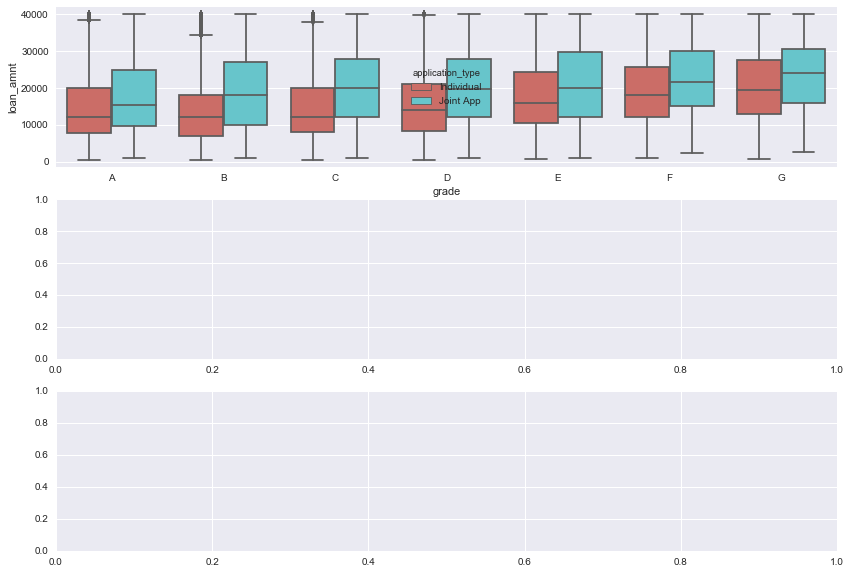

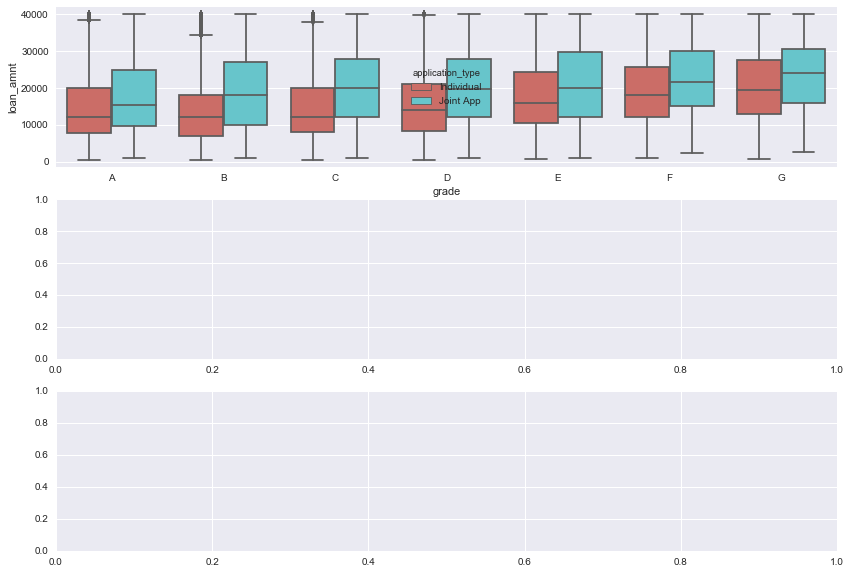

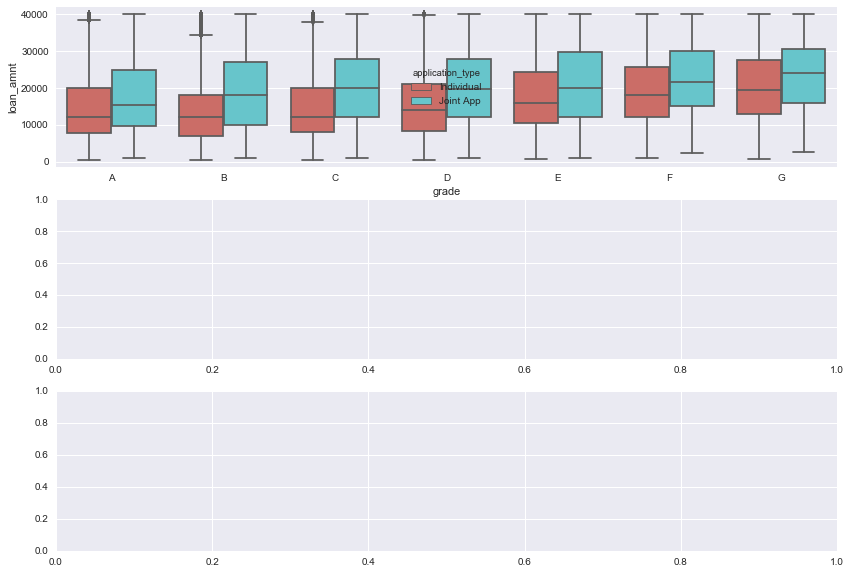

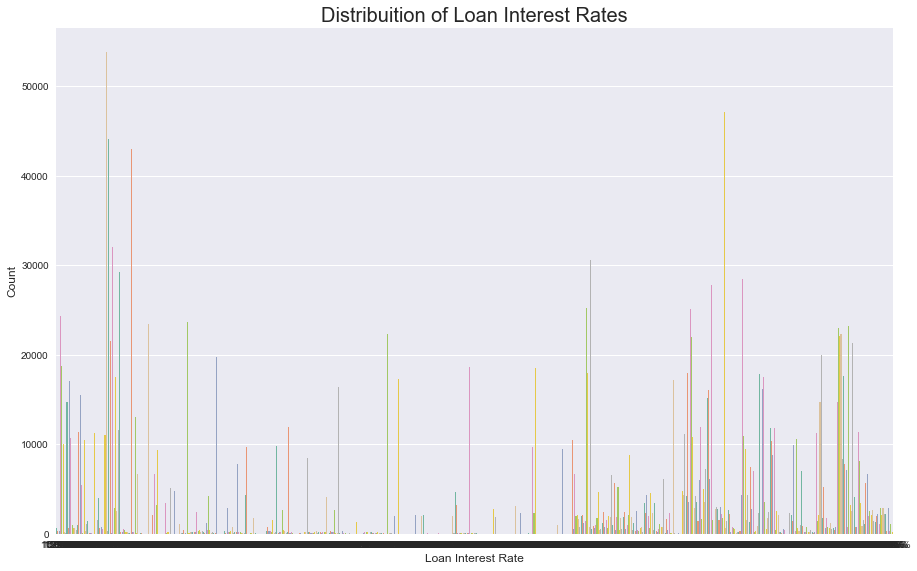

In [76]:
# Explore distrubution of loan interest rates
plt.figure(figsize = (15,12))
plt.subplot(211)
g1 = sns.countplot(x="int_rate",data=df, 
                   palette="Set2")
g1.set_xlabel("Loan Interest Rate", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Distribuition of Loan Interest Rates", fontsize=20)

plt.subplots_adjust(wspace = 0.4, hspace = 1.2,top = 2)

plt.show()

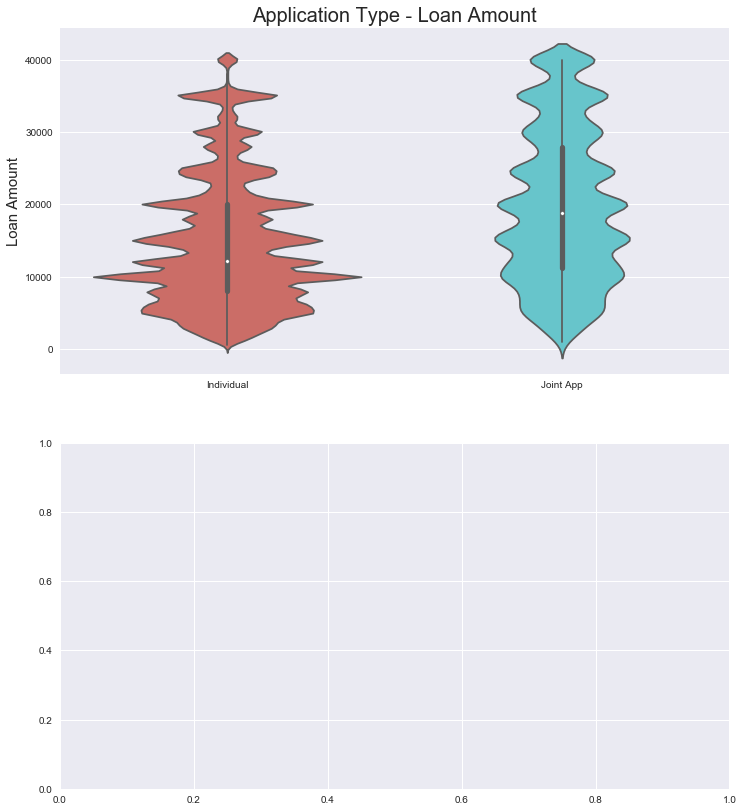

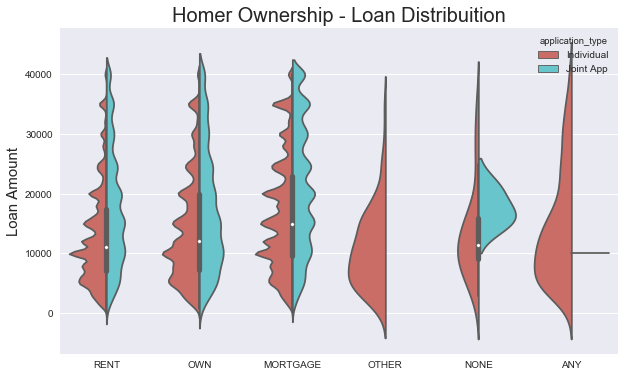

In [49]:
plt.figure(figsize = (10,6))

g = sns.violinplot(x="home_ownership",y="loan_amnt",data=df,
               kind="violin",
               split=True,palette="hls",
               hue="application_type")
g.set_title("Homer Ownership - Loan Distribuition", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.show()

Purposes count description: 
application_type    Individual  Joint App
purpose                                  
car                      19829        566
credit_card             401026      12820
debt_consolidation     1031471      41847
educational                424          0
home_improvement        120451       4898
house                     9988        297
major_purchase           40716       1324
medical                  21452       1179
moving                   12570        463
other                   110453       3703
renewable_energy          1195         38
small_business           20836        616
vacation                 12469        304
wedding                   2354          1


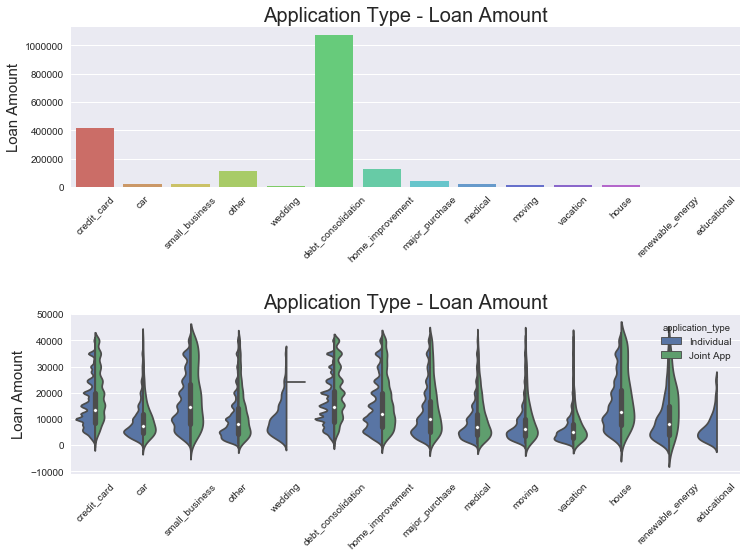

In [77]:
# Explore Loan Purpose
print("Purposes count description: ")
print(pd.crosstab(df.purpose, df.application_type))

plt.figure(figsize = (12,8))

plt.subplot(211)
g = sns.countplot(x="purpose",data=df,
                  palette='hls')
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Application Type - Loan Amount", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.subplot(212)
g1 = sns.violinplot(x="purpose",y="loan_amnt",data=df,
               hue="application_type", split=True)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_title("Application Type - Loan Amount", fontsize=20)
g1.set_xlabel("", fontsize=15)
g1.set_ylabel("Loan Amount", fontsize=15)

plt.subplots_adjust(wspace = 0.2, hspace = 0.8,top = 0.9)
plt.show()

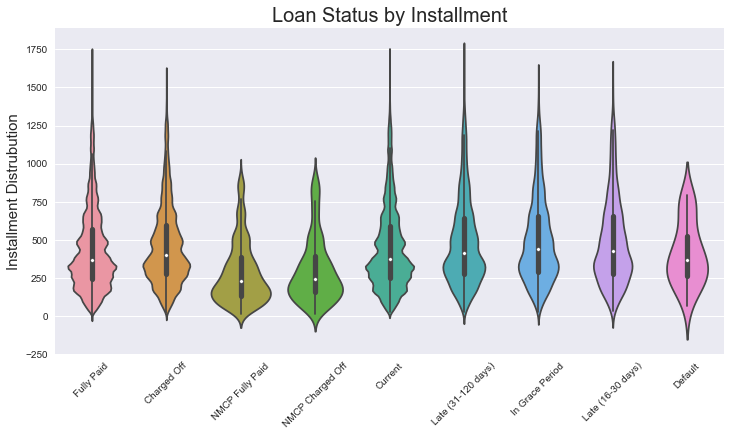

In [46]:
plt.figure(figsize = (12,6))

g = sns.violinplot(x='loan_status', y="installment",
                   data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Installment Distrubution", fontsize=15)
g.set_title("Loan Status by Installment", fontsize=20)

plt.show()

In [37]:
df.loc[df.loan_status == \
            'Does not meet the credit policy. Status:Fully Paid', 'loan_status'] = 'NMCP Fully Paid'
df.loc[df.loan_status == \
            'Does not meet the credit policy. Status:Charged Off', 'loan_status'] = 'NMCP Charged Off'

Current               812194
Fully Paid            811895
Charged Off           208657
Late (31-120 days)     19535
In Grace Period        13634
Late (16-30 days)       4602
NMCP Fully Paid         1988
NMCP Charged Off         761
Default                   24
Name: loan_status, dtype: int64


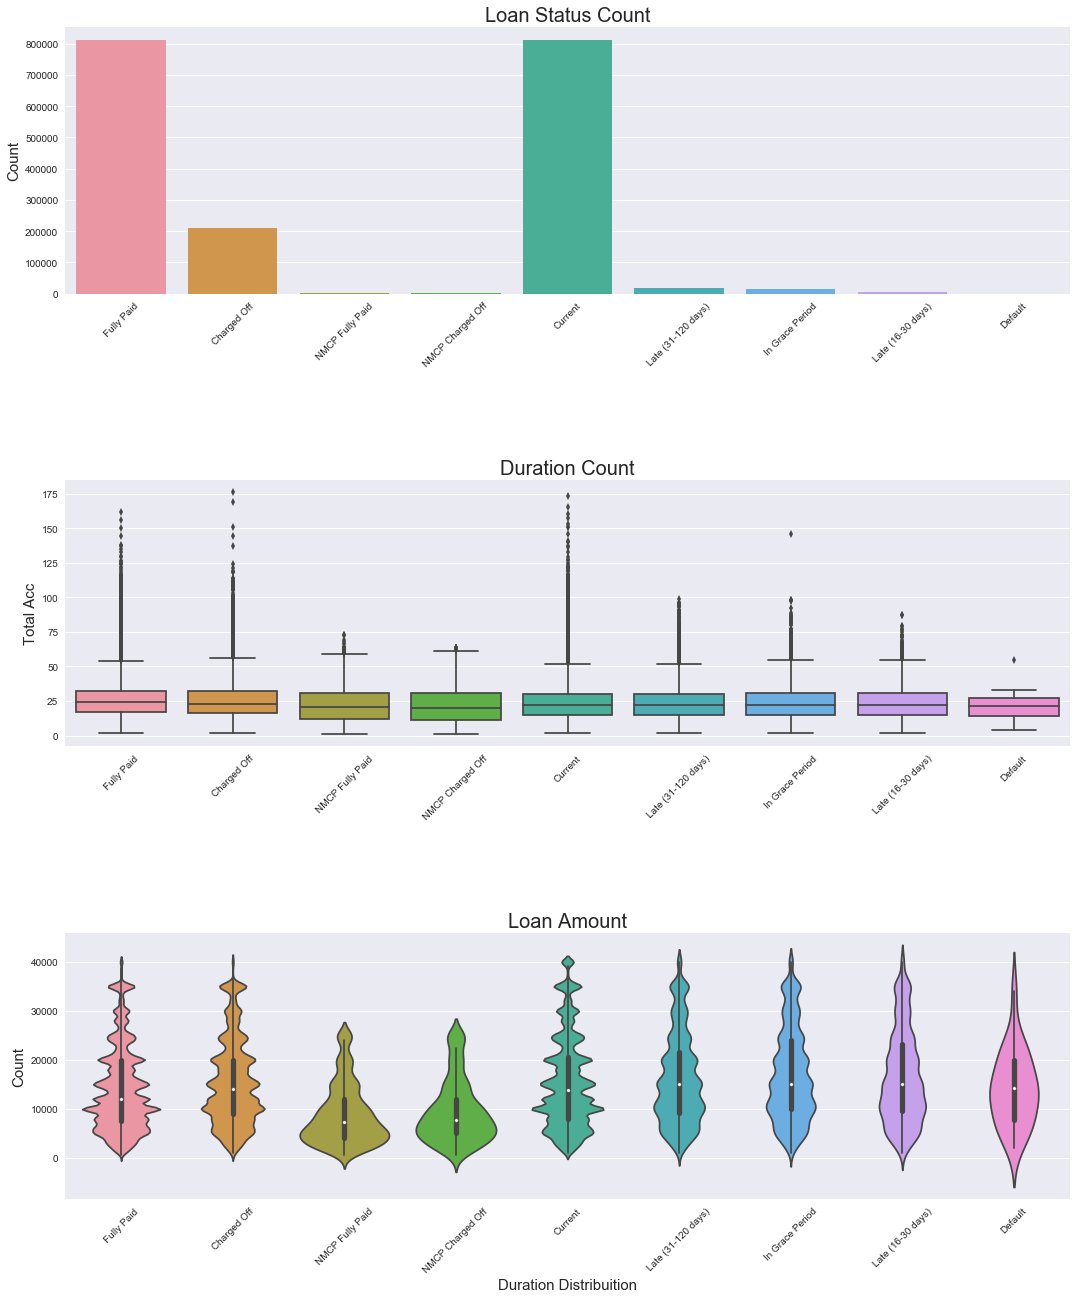

In [78]:
print(df.loan_status.value_counts())

plt.figure(figsize = (18,21))

plt.subplot(311)
g = sns.countplot(x="loan_status", data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=15)
g.set_title("Loan Status Count", fontsize=20)

plt.subplot(312)
g1 = sns.boxplot(x="loan_status", y="total_acc", data=df)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Total Acc", fontsize=15)
g1.set_title("Duration Count", fontsize=20)

plt.subplot(313)
g2 = sns.violinplot(x="loan_status", y="loan_amnt", data=df)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
g2.set_xlabel("Duration Distribuition", fontsize=15)
g2.set_ylabel("Count", fontsize=15)
g2.set_title("Loan Amount", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.7,top = 0.9)

plt.show()